# Project Title
### Data Engineering Capstone Project

#### Project Summary
The objective of this project is to build an analytics database for detecting relation between temperature and air quality and electric vehicles sellings all over the world and specifically in Europe.

This database will be helpful to find answers for questions such as:

* How has weather and air quality in Europe changed over the years?

* What are the countries with more electric vehicles? Has the air a better quality?


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
! pip install -U pandasql

  Running setup.py bdist_wheel for pandasql ... done
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [2]:
! pip install -U  plotly

    100% |████████████████████████████████| 15.6MB 2.0MB/s eta 0:00:01   17% |█████▌                          | 2.7MB 76.2MB/s eta 0:00:01
  Found existing installation: plotly 2.0.15
    Uninstalling plotly-2.0.15:
      Successfully uninstalled plotly-2.0.15


In [3]:
! pip install -U  missingno

In [4]:
# Do all imports and installs here
import os
import configparser
import pandas as pd
from datetime import datetime 
import missingno as msno
from pandas.io.json import json_normalize #package for flattening json in pandas df
from pandasql import sqldf

from pyspark.sql import SparkSession, SQLContext, GroupedData, HiveContext
import pyspark.sql.functions as funcs
from pyspark.sql.functions import isnan, when, count, col, sum, udf, dayofmonth, dayofweek, month, year, weekofyear, avg, monotonically_increasing_id
from pyspark.sql.functions import year, month, dayofweek, dayofmonth, weekofyear, date_format
from pyspark.sql.functions import *
from pyspark.sql.functions import date_add as d_add
from pyspark.sql.functions import lit
from pyspark.sql.types import *
from pyspark.sql.types import DoubleType, StringType, IntegerType, FloatType
from pyspark.sql import functions as F
from pyspark.sql import Row

import json 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [5]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = "/opt/conda/bin:/opt/spark-2.4.3-bin-hadoop2.7/bin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/jvm/java-8-openjdk-amd64/bin"
os.environ["SPARK_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ["HADOOP_HOME"] = "/opt/spark-2.4.3-bin-hadoop2.7"
os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

### Create a spark session

In [6]:
MAX_MEMORY = '30G'

spark = SparkSession.builder\
        .config("spark.jars.repositories", "https://repos.spark-packages.org/")\
        .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0,saurfang:spark-sas7bdat:2.0.0-s_2.11")\
        .enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>
The objective of this project is to build an analytics database for detecting a relation between temperature, air quality and electric vehicles sellings all over the world and specifically in Europe.

This database will be helpful to find answers for questions such as:

- How has weather and air quality in Europe changed over the years?
- What are the countries with more electric vehicles? 
- Has the air a better quality in the countries with more electric vehicles?
- Is there a relation between the longevity and the number of electric vehicles in a country?

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 
This project pulls data from several sources and create a star schema with some facts and dimensional tables.
The datasets used for this project are:
- GlobalLandTemperatures from Udacity 
- Air Quality from Opendatasoft
- Electric Vehicles Sellings from IEA 
- World Population Data from https://www.worlddata.info/

This Capstone project will have the following steps:
1. Use Spark to load the datasets into dataframes
2. An Exploratory data analysis EDA to explore all the dataset details
3. Perform some cleaning on all the datasets
4. Prepare the dimensional and facts tables

The technology used is AWS S3 buckets where the source data resides, then the data will be staged and processed with Spark.


## Temperature Data

### Let's load the Global Land Temperatures by city dataset


In [7]:
# Let's load the temperature data
file_temp = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temp  = spark.read.csv(file_temp, inferSchema=True, header=True, sep=',')

#### And view the dataset in its raw format

In [8]:
df_temp.show()

+-------------------+-------------------+-----------------------------+-----+-------+--------+---------+
|                 dt| AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+-------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|              6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-04-01 00:00:00| 5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744-05-01 00:00:00|             10.644|           1.2

In [9]:
# I prefer this view with Pandas
df_temp.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [10]:
df_temp.summary().show()

+-------+------------------+-----------------------------+--------+-----------+--------+---------+
|summary|AverageTemperature|AverageTemperatureUncertainty|    City|    Country|Latitude|Longitude|
+-------+------------------+-----------------------------+--------+-----------+--------+---------+
|  count|           8235082|                      8235082| 8599212|    8599212| 8599212|  8599212|
|   mean|16.727432636250857|           1.0285747414536999|    null|       null|    null|     null|
| stddev|  10.3534424825344|           1.1297332887133766|    null|       null|    null|     null|
|    min|-42.70399999999999|                        0.034|A Coruña|Afghanistan|   0.80N|    0.00W|
|    25%|            10.304|          0.33799999999999997|    null|       null|    null|     null|
|    50%|            18.833|                        0.591|    null|       null|    null|     null|
|    75%|            25.211|                         1.35|    null|       null|    null|     null|
|    max| 

#### Now we are going to print the schema of the temperature raw dataset

In [11]:
df_temp.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



#### Data dictionary of this dataset that contains 7 columns
##### dt: datetime it shows the date of the observation
##### AverageTemperature: The average temperature of the observation
##### AverageTemperatureUncertainty:
##### City: The city where the temperature observation was taken
##### Country: The Country where the temperature observation was taken
##### Latitude: The Latitude where the temperature observation was taken
##### Longitude: The Longitude where the temperature observation was taken

In [12]:
# Let's see if we have null values
df_temp.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_temp.columns)).show()

+---+------------------+-----------------------------+----+-------+--------+---------+
| dt|AverageTemperature|AverageTemperatureUncertainty|City|Country|Latitude|Longitude|
+---+------------------+-----------------------------+----+-------+--------+---------+
|  0|            364130|                       364130|   0|      0|       0|        0|
+---+------------------+-----------------------------+----+-------+--------+---------+



In [13]:
# As we have several null values in AverageTemperature and AverageTemperatureUncertaninty columns 
# we are going to remove those rows
# We could impute with a media/median value, but we don't need such a level of detail for the purpose of this project
df_clean_temp = df_temp.na.drop(how="any")

In [14]:
df_clean_temp.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
2,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
3,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
4,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E


In [15]:
# We create a view of the temperature dataset
# so that we can make SQL queries on the dataset
df_clean_temp.createOrReplaceTempView("temp_table")

In [16]:
# Let's check the number of rows after dropping nulls (yet more than 8 million rows)
df_clean_temp.count()

8235082

In [17]:
# Let's check how many distinct datetimes there are in the dataset --> 3167 distinct dates
spark.sql("""
SELECT COUNT (DISTINCT dt)
FROM temp_table
""").show()

+------------------+
|count(DISTINCT dt)|
+------------------+
|              3167|
+------------------+



In [18]:
# And now let's check how many cities there are in the dataset --> 3448 distinct cities
spark.sql("""
SELECT COUNT (DISTINCT City)
FROM temp_table
""").show()

+--------------------+
|count(DISTINCT City)|
+--------------------+
|                3448|
+--------------------+



In [19]:
# And how many -distinct- countries are in the dataset? --> 159 different countries
spark.sql("""
SELECT COUNT (DISTINCT Country)
FROM temp_table
""").show()

+-----------------------+
|count(DISTINCT Country)|
+-----------------------+
|                    159|
+-----------------------+



In [20]:
# Just curiosity: Let's check how many entries of Barcelona/Spain we can find within the dataset

spark.sql("""
SELECT *
FROM temp_table
WHERE City = "Barcelona" AND Country = "Spain"
""").show()

+-------------------+------------------+-----------------------------+---------+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty|     City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+---------+-------+--------+---------+
|1743-11-01 00:00:00|            13.808|           1.9180000000000001|Barcelona|  Spain|  40.99N|    2.13E|
|1744-04-01 00:00:00|            15.406|                        1.931|Barcelona|  Spain|  40.99N|    2.13E|
|1744-05-01 00:00:00|             15.89|                         1.84|Barcelona|  Spain|  40.99N|    2.13E|
|1744-06-01 00:00:00|20.067999999999998|                         1.82|Barcelona|  Spain|  40.99N|    2.13E|
|1744-07-01 00:00:00|            22.547|           1.8119999999999998|Barcelona|  Spain|  40.99N|    2.13E|
|1744-09-01 00:00:00|            20.477|                        1.841|Barcelona|  Spain|  40.99N|    2.13E|
|1744-10-01 00:00:00|       

In [22]:
# Now we select the Top Ten countries with the maximum average temperature 
spark.sql("""
SELECT MAX (AverageTemperature), Country
FROM temp_table
GROUP BY Country
ORDER BY MAX(AverageTemperature) DESC
LIMIT 10
""").show()

+-----------------------+--------------------+
|max(AverageTemperature)|             Country|
+-----------------------+--------------------+
|                 39.651|             Algeria|
|      39.15600000000001|                Iran|
|                 38.283|                Iraq|
|                 38.049|        Saudi Arabia|
|                 37.938|            Pakistan|
|                 37.812|               Qatar|
|      37.52200000000001|               India|
|     37.446999999999996|             Bahrain|
|                 36.371|United Arab Emirates|
|     36.224000000000004|               Egypt|
+-----------------------+--------------------+



In [23]:
# And we select the Top Ten countries with the minimum average temperature 
spark.sql("""
SELECT MIN (AverageTemperature),Country
FROM temp_table
GROUP BY Country
ORDER BY MIN(AverageTemperature) ASC
LIMIT 10
""").show()

+-----------------------+-------------+
|min(AverageTemperature)|      Country|
+-----------------------+-------------+
|     -42.70399999999999|       Russia|
|                 -34.94|        China|
|                -31.986|     Mongolia|
|    -31.825000000000006|       Canada|
|                 -30.18|   Kazakhstan|
|                -25.163|United States|
|                -20.631|      Finland|
|                -18.537|      Belarus|
|    -17.819000000000006|      Estonia|
|                -17.686|      Ukraine|
+-----------------------+-------------+



## DATASET AIR QUALITY

### Let's load the Dataset Air Quality by city dataset

#### I am going to use a dataset of air quality, so first let's analyse it

In [27]:
df_aq = pd.read_json("openaq.json")

In [28]:
df_aq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43471 entries, 0 to 43470
Data columns (total 10 columns):
city                        27182 non-null object
coordinates                 43252 non-null object
country                     43471 non-null object
country_name_en             43356 non-null object
location                    43471 non-null object
measurements_lastupdated    43471 non-null object
measurements_parameter      43471 non-null object
measurements_sourcename     43471 non-null object
measurements_unit           43471 non-null object
measurements_value          43471 non-null float64
dtypes: float64(1), object(9)
memory usage: 3.3+ MB


In [29]:
# Let's have an overview of this dataset
df_aq.describe()

,measurements_value
count,4.347100e+04
mean,7.684342e+02
std,3.270551e+04
min,-4.905140e+04
25%,1.800000e+00
50%,1.090000e+01
75%,3.300000e+01
max,3.198676e+06


In [30]:
# Let's see an example of the data
df_aq.head()

,city,coordinates,country,country_name_en,location,measurements_lastupdated,measurements_parameter,measurements_sourcename,measurements_unit,measurements_value
0,None,"{'lon': 106.9242, 'lat': 27.7019}",CN,China,凤凰山,2021-08-09T13:00:00+02:00,CO,ChinaAQIData,µg/m³,200.0
1,None,"{'lon': 125.37159999999999, 'lat': 43.87720000...",CN,China,劳动公园,2021-08-09T13:00:00+02:00,PM10,ChinaAQIData,µg/m³,55.0
2,None,"{'lon': 111.717, 'lat': 40.7612}",CN,China,化肥厂生活区,2021-08-09T13:00:00+02:00,PM10,ChinaAQIData,µg/m³,44.0
3,None,"{'lon': 117.97759999999998, 'lat': 37.393}",CN,China,北中新校,2021-08-09T13:00:00+02:00,SO2,ChinaAQIData,µg/m³,12.0
4,None,"{'lon': 119.00700000000002, 'lat': 33.57499999...",CN,China,北京南路,2021-08-09T13:00:00+02:00,NO2,ChinaAQIData,µg/m³,29.0


In [31]:
df_aq[df_aq["country_name_en"]=="Spain"]

,city,coordinates,country,country_name_en,location,measurements_lastupdated,measurements_parameter,measurements_sourcename,measurements_unit,measurements_value
239,Murcia,"{'lon': -1.14472222, 'lat': 37.9936111094788}",ES,Spain,ES1633A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,26.70
240,Valencia/València,"{'lon': -0.23472222, 'lat': 39.6672222194722}",ES,Spain,ES1185A,2023-09-17T09:00:00+02:00,PM2.5,EEA Spain,µg/m³,10.00
241,Alicante/Alacant,"{'lon': -0.8033333299999991, 'lat': 38.4547222...",ES,Spain,ES1914A,2023-09-17T09:00:00+02:00,SO2,EEA Spain,µg/m³,4.00
242,Lleida,"{'lon': 0.734719999999999, 'lat': 41.393889999...",ES,Spain,ES0014R,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,1.58
243,Madrid,"{'lon': -3.68555555, 'lat': 40.4097222194698}",ES,Spain,ES1939A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,1.00
244,Madrid,"{'lon': -3.70333333, 'lat': 40.4191666594698}",ES,Spain,ES1422A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,1.00
245,Madrid,"{'lon': -3.68833333, 'lat': 40.4658333294697}",ES,Spain,ES1940A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,1.00
246,Alicante/Alacant,"{'lon': -0.85277777, 'lat': 38.0847222194784}",ES,Spain,ES1677A,2023-04-26T09:00:00+02:00,CO,EEA Spain,µg/m³,100.00
247,Valencia/València,"{'lon': -0.69722222, 'lat': 38.7880555494754}",ES,Spain,ES1711A,2023-07-25T09:00:00+02:00,NO2,EEA Spain,µg/m³,2.00
248,Madrid,"{'lon': -3.73194444, 'lat': 40.3947222194698}",ES,Spain,ES0126A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,28.00


In [32]:
df_aq[df_aq["city"]=="Barcelona"]

,city,coordinates,country,country_name_en,location,measurements_lastupdated,measurements_parameter,measurements_sourcename,measurements_unit,measurements_value
260,Barcelona,"{'lon': 1.999634718, 'lat': 41.4007707664672}",ES,Spain,ES2011A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,16.0
271,Barcelona,"{'lon': 2.153385124, 'lat': 41.3987432504672}",ES,Spain,ES1480A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,13.0
442,Barcelona,"{'lon': 2.1238973, 'lat': 41.41843}",ES,Spain,Barcelona,2023-09-17T04:00:00+02:00,O3,catalonia-mediambient,µg/m³,91.0
3114,Barcelona,"{'lon': 2.15382196, 'lat': 41.3853432834672}",ES,Spain,ES1438A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,25.0
4484,Barcelona,"{'lon': 2.1874167350000002, 'lat': 41.38641393...",ES,Spain,ES1679A,2023-09-17T09:00:00+02:00,O3,EEA Spain,µg/m³,34.0
4490,Barcelona,"{'lon': 2.013824628, 'lat': 41.3134752074674}",ES,Spain,ES1903A,2023-09-17T08:00:00+02:00,SO2,EEA Spain,µg/m³,3.0
4687,Barcelona,"{'lon': 2.1238973, 'lat': 41.41843}",ES,Spain,Barcelona,2023-09-16T04:00:00+02:00,NOX,catalonia-mediambient,µg/m³,3.0
6026,Barcelona,"{'lon': 1.625893365, 'lat': 41.5776268914668}",ES,Spain,ES1135A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,3.0
6050,Barcelona,"{'lon': 2.1874167350000002, 'lat': 41.38641393...",ES,Spain,ES1679A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,1.0
6051,Barcelona,"{'lon': 2.153385124, 'lat': 41.3987432504672}",ES,Spain,ES1480A,2023-09-17T04:00:00+02:00,NOX,EEA Spain,µg/m³,20.0


In [33]:
df_aq['dt']= pd.to_datetime(df_aq['measurements_lastupdated'])

In [34]:
df_aq['year'] = df_aq['dt'].dt.year

In [35]:
df_aq['month'] = df_aq['dt'].dt.month

In [36]:
df_aq['day'] = df_aq['dt'].dt.day

In [37]:
df_aq[df_aq['coordinates'].notnull()]['coordinates']

0                        {'lon': 106.9242, 'lat': 27.7019}
1        {'lon': 125.37159999999999, 'lat': 43.87720000...
2                         {'lon': 111.717, 'lat': 40.7612}
3               {'lon': 117.97759999999998, 'lat': 37.393}
4        {'lon': 119.00700000000002, 'lat': 33.57499999...
5              {'lon': 108.31410000000001, 'lat': 22.8528}
6                        {'lon': 113.1064, 'lat': 22.6058}
7        {'lon': 106.63509999999998, 'lat': 30.48650000...
8             {'lon': 112.4258, 'lat': 39.319700000000005}
9              {'lon': 130.36480000000003, 'lat': 46.8032}
10             {'lon': 118.17049999999999, 'lat': 39.6506}
11                       {'lon': 123.1289, 'lat': 41.0228}
12             {'lon': 115.5213, 'lat': 38.89589999999999}
13                       {'lon': 113.7383, 'lat': 22.9658}
14                        {'lon': 84.8988, 'lat': 45.5893}
15             {'lon': 113.10940000000001, 'lat': 29.3578}
16       {'lon': 114.49400000000001, 'lat': 22.54220000.

In [38]:
df_aq

,city,coordinates,country,country_name_en,location,measurements_lastupdated,measurements_parameter,measurements_sourcename,measurements_unit,measurements_value,dt,year,month,day
0,None,"{'lon': 106.9242, 'lat': 27.7019}",CN,China,凤凰山,2021-08-09T13:00:00+02:00,CO,ChinaAQIData,µg/m³,200.000000,2021-08-09 11:00:00,2021,8,9
1,None,"{'lon': 125.37159999999999, 'lat': 43.87720000...",CN,China,劳动公园,2021-08-09T13:00:00+02:00,PM10,ChinaAQIData,µg/m³,55.000000,2021-08-09 11:00:00,2021,8,9
2,None,"{'lon': 111.717, 'lat': 40.7612}",CN,China,化肥厂生活区,2021-08-09T13:00:00+02:00,PM10,ChinaAQIData,µg/m³,44.000000,2021-08-09 11:00:00,2021,8,9
3,None,"{'lon': 117.97759999999998, 'lat': 37.393}",CN,China,北中新校,2021-08-09T13:00:00+02:00,SO2,ChinaAQIData,µg/m³,12.000000,2021-08-09 11:00:00,2021,8,9
4,None,"{'lon': 119.00700000000002, 'lat': 33.57499999...",CN,China,北京南路,2021-08-09T13:00:00+02:00,NO2,ChinaAQIData,µg/m³,29.000000,2021-08-09 11:00:00,2021,8,9
5,None,"{'lon': 108.31410000000001, 'lat': 22.8528}",CN,China,北湖,2021-08-09T13:00:00+02:00,PM2.5,ChinaAQIData,µg/m³,15.000000,2021-08-09 11:00:00,2021,8,9
6,None,"{'lon': 113.1064, 'lat': 22.6058}",CN,China,北街,2021-08-09T13:00:00+02:00,SO2,ChinaAQIData,µg/m³,5.000000,2021-08-09 11:00:00,2021,8,9
7,None,"{'lon': 106.63509999999998, 'lat': 30.48650000...",CN,China,北辰小学,2021-08-09T13:00:00+02:00,PM10,ChinaAQIData,µg/m³,12.000000,2021-08-09 11:00:00,2021,8,9
8,None,"{'lon': 112.4258, 'lat': 39.319700000000005}",CN,China,区政府,2021-08-09T13:00:00+02:00,PM10,ChinaAQIData,µg/m³,43.000000,2021-08-09 11:00:00,2021,8,9
9,None,"{'lon': 130.36480000000003, 'lat': 46.8032}",CN,China,十一中,2021-08-09T13:00:00+02:00,O3,ChinaAQIData,µg/m³,29.000000,2021-08-09 11:00:00,2021,8,9


In [39]:
df_aq_bcn = df_aq[df_aq["city"]=="Barcelona"]

In [40]:
df_aq_bcn = df_aq_bcn.reset_index()

In [41]:
len(df_aq_bcn)

64

In [42]:
df_aq_bcn

,index,city,coordinates,country,country_name_en,location,measurements_lastupdated,measurements_parameter,measurements_sourcename,measurements_unit,measurements_value,dt,year,month,day
0,260,Barcelona,"{'lon': 1.999634718, 'lat': 41.4007707664672}",ES,Spain,ES2011A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,16.0,2023-09-17 07:00:00,2023,9,17
1,271,Barcelona,"{'lon': 2.153385124, 'lat': 41.3987432504672}",ES,Spain,ES1480A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,13.0,2023-09-17 07:00:00,2023,9,17
2,442,Barcelona,"{'lon': 2.1238973, 'lat': 41.41843}",ES,Spain,Barcelona,2023-09-17T04:00:00+02:00,O3,catalonia-mediambient,µg/m³,91.0,2023-09-17 02:00:00,2023,9,17
3,3114,Barcelona,"{'lon': 2.15382196, 'lat': 41.3853432834672}",ES,Spain,ES1438A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,25.0,2023-09-17 07:00:00,2023,9,17
4,4484,Barcelona,"{'lon': 2.1874167350000002, 'lat': 41.38641393...",ES,Spain,ES1679A,2023-09-17T09:00:00+02:00,O3,EEA Spain,µg/m³,34.0,2023-09-17 07:00:00,2023,9,17
5,4490,Barcelona,"{'lon': 2.013824628, 'lat': 41.3134752074674}",ES,Spain,ES1903A,2023-09-17T08:00:00+02:00,SO2,EEA Spain,µg/m³,3.0,2023-09-17 06:00:00,2023,9,17
6,4687,Barcelona,"{'lon': 2.1238973, 'lat': 41.41843}",ES,Spain,Barcelona,2023-09-16T04:00:00+02:00,NOX,catalonia-mediambient,µg/m³,3.0,2023-09-16 02:00:00,2023,9,16
7,6026,Barcelona,"{'lon': 1.625893365, 'lat': 41.5776268914668}",ES,Spain,ES1135A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,3.0,2023-09-17 07:00:00,2023,9,17
8,6050,Barcelona,"{'lon': 2.1874167350000002, 'lat': 41.38641393...",ES,Spain,ES1679A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,1.0,2023-09-17 07:00:00,2023,9,17
9,6051,Barcelona,"{'lon': 2.153385124, 'lat': 41.3987432504672}",ES,Spain,ES1480A,2023-09-17T04:00:00+02:00,NOX,EEA Spain,µg/m³,20.0,2023-09-17 02:00:00,2023,9,17


In [43]:
df_aq_bcn['lon'] = df_aq_bcn.apply(lambda row: row['coordinates']['lon'], axis=1)

In [44]:
df_aq_bcn['lat'] = df_aq_bcn.apply(lambda row: row['coordinates']['lat'], axis=1)

In [45]:
df_aq_bcn

,index,city,coordinates,country,country_name_en,location,measurements_lastupdated,measurements_parameter,measurements_sourcename,measurements_unit,measurements_value,dt,year,month,day,lon,lat
0,260,Barcelona,"{'lon': 1.999634718, 'lat': 41.4007707664672}",ES,Spain,ES2011A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,16.0,2023-09-17 07:00:00,2023,9,17,1.999635,41.400771
1,271,Barcelona,"{'lon': 2.153385124, 'lat': 41.3987432504672}",ES,Spain,ES1480A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,13.0,2023-09-17 07:00:00,2023,9,17,2.153385,41.398743
2,442,Barcelona,"{'lon': 2.1238973, 'lat': 41.41843}",ES,Spain,Barcelona,2023-09-17T04:00:00+02:00,O3,catalonia-mediambient,µg/m³,91.0,2023-09-17 02:00:00,2023,9,17,2.123897,41.418430
3,3114,Barcelona,"{'lon': 2.15382196, 'lat': 41.3853432834672}",ES,Spain,ES1438A,2023-09-17T09:00:00+02:00,NO2,EEA Spain,µg/m³,25.0,2023-09-17 07:00:00,2023,9,17,2.153822,41.385343
4,4484,Barcelona,"{'lon': 2.1874167350000002, 'lat': 41.38641393...",ES,Spain,ES1679A,2023-09-17T09:00:00+02:00,O3,EEA Spain,µg/m³,34.0,2023-09-17 07:00:00,2023,9,17,2.187417,41.386414
5,4490,Barcelona,"{'lon': 2.013824628, 'lat': 41.3134752074674}",ES,Spain,ES1903A,2023-09-17T08:00:00+02:00,SO2,EEA Spain,µg/m³,3.0,2023-09-17 06:00:00,2023,9,17,2.013825,41.313475
6,4687,Barcelona,"{'lon': 2.1238973, 'lat': 41.41843}",ES,Spain,Barcelona,2023-09-16T04:00:00+02:00,NOX,catalonia-mediambient,µg/m³,3.0,2023-09-16 02:00:00,2023,9,16,2.123897,41.418430
7,6026,Barcelona,"{'lon': 1.625893365, 'lat': 41.5776268914668}",ES,Spain,ES1135A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,3.0,2023-09-17 07:00:00,2023,9,17,1.625893,41.577627
8,6050,Barcelona,"{'lon': 2.1874167350000002, 'lat': 41.38641393...",ES,Spain,ES1679A,2023-09-17T09:00:00+02:00,NO,EEA Spain,µg/m³,1.0,2023-09-17 07:00:00,2023,9,17,2.187417,41.386414
9,6051,Barcelona,"{'lon': 2.153385124, 'lat': 41.3987432504672}",ES,Spain,ES1480A,2023-09-17T04:00:00+02:00,NOX,EEA Spain,µg/m³,20.0,2023-09-17 02:00:00,2023,9,17,2.153385,41.398743


In [46]:
df_aq_bcn_nox = df_aq_bcn[df_aq_bcn['measurements_parameter']=='NO2']

In [47]:
df_aq_bcn_nox = df_aq_bcn_nox.reset_index()

In [50]:
# plotting map using plotly
fig = px.scatter_geo(df_aq_bcn_nox, lat = 'lat', lon = 'lon', color = 'location')

# setting title for the map
fig.update_layout(title = 'Measurements Locations in Barcelona', title_x = 0.5)

In [51]:
df_aq[df_aq["city"]=="Barcelona"]["measurements_value"]

260       16.0
271       13.0
442       91.0
3114      25.0
4484      34.0
4490       3.0
4687       3.0
6026       3.0
6050       1.0
6051      20.0
6052     200.0
6208       9.0
6210       3.0
6472      19.0
6630       2.0
6631       8.0
8223       9.0
8246       2.0
8410       2.0
8411       5.0
9542     200.0
9567      13.0
9645       2.0
11870     27.0
14600      1.0
14725     24.0
16683      8.0
16836      2.0
16837      1.0
19962      3.0
         ...  
24079     24.0
26324      1.0
27353     28.0
28859      5.0
28913     16.0
28914     18.0
28919     40.0
30135    200.0
30136      7.0
30137     17.0
30143     10.0
31823      1.0
32704      3.0
32711      5.0
34451      4.0
34455     12.0
34456      1.0
34640     16.0
36578     14.0
37122    300.0
39614     20.0
39795     45.0
39802    200.0
41905      1.0
41906      7.0
42506     71.0
42524     55.0
42525      3.0
42616     22.0
42623      1.0
Name: measurements_value, Length: 64, dtype: float64

## ELECTRIC VEHICLE SELLINGS

In [52]:
df_el = pd.read_csv("./IEA-EV-data.csv")

In [53]:
df_el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7434 entries, 0 to 7433
Data columns (total 8 columns):
region        7434 non-null object
category      7434 non-null object
parameter     7434 non-null object
mode          7434 non-null object
powertrain    7434 non-null object
year          7434 non-null int64
unit          7434 non-null object
value         7434 non-null float64
dtypes: float64(1), int64(1), object(6)
memory usage: 464.7+ KB


In [54]:
df_el.region.unique()

array(['Australia', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China',
       'Denmark', 'Europe', 'Finland', 'France', 'Germany', 'Greece',
       'Iceland', 'India', 'Indonesia', 'Italy', 'Japan', 'Korea',
       'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Other Europe',
       'Poland', 'Portugal', 'Rest of the world', 'South Africa', 'Spain',
       'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'USA',
       'World'], dtype=object)

In [55]:
df_el.head()

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,sales,49.00000
1,Australia,Historical,EV stock,Cars,BEV,2011,stock,49.00000
2,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00046
3,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
4,Australia,Historical,EV sales share,Cars,EV,2012,percent,0.03000


In [56]:
df_el.powertrain.unique()

array(['BEV', 'EV', 'PHEV', 'Publicly available fast',
       'Publicly available slow'], dtype=object)

In [57]:
df_el.parameter.unique()

array(['EV sales', 'EV stock', 'EV stock share', 'EV sales share',
       'EV charging points', 'Oil displacement Mbd',
       'Oil displacement Mlge', 'Electricity demand'], dtype=object)

In [58]:
df_el.category.unique()

array(['Historical', 'Projection-STEPS', 'Projection-APS'], dtype=object)

In [59]:
df_el.unit.unique()

array(['sales', 'stock', 'percent', 'charging points',
       'Milion barrels per day', 'Milion litres gasoline equivalent', 'GWh'], dtype=object)

In [60]:
test =  df_el[(df_el["category"]=='Historical')  & (df_el["mode"]=="Cars")& (df_el["unit"]=="sales") ]

In [61]:
test

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,sales,49.0
7,Australia,Historical,EV sales,Cars,PHEV,2012,sales,80.0
8,Australia,Historical,EV sales,Cars,BEV,2012,sales,170.0
11,Australia,Historical,EV sales,Cars,BEV,2013,sales,190.0
12,Australia,Historical,EV sales,Cars,PHEV,2013,sales,100.0
19,Australia,Historical,EV sales,Cars,PHEV,2014,sales,950.0
20,Australia,Historical,EV sales,Cars,BEV,2014,sales,370.0
23,Australia,Historical,EV sales,Cars,BEV,2015,sales,760.0
24,Australia,Historical,EV sales,Cars,PHEV,2015,sales,1000.0
31,Australia,Historical,EV sales,Cars,PHEV,2016,sales,700.0


In [62]:
sales_in_spain_bev = df_el[(df_el["region"]=='Spain') & (df_el["unit"]=="sales") & (df_el["mode"]=="Cars") & (df_el["powertrain"]=="BEV")]

In [63]:
sales_in_spain_bev

,region,category,parameter,mode,powertrain,year,unit,value
5511,Spain,Historical,EV sales,Cars,BEV,2010,sales,76.0
5520,Spain,Historical,EV sales,Cars,BEV,2011,sales,390.0
5529,Spain,Historical,EV sales,Cars,BEV,2012,sales,430.0
5543,Spain,Historical,EV sales,Cars,BEV,2013,sales,810.0
5552,Spain,Historical,EV sales,Cars,BEV,2014,sales,1400.0
5571,Spain,Historical,EV sales,Cars,BEV,2015,sales,1300.0
5580,Spain,Historical,EV sales,Cars,BEV,2016,sales,2000.0
5607,Spain,Historical,EV sales,Cars,BEV,2017,sales,3900.0
5616,Spain,Historical,EV sales,Cars,BEV,2018,sales,6000.0
5647,Spain,Historical,EV sales,Cars,BEV,2019,sales,10000.0


In [64]:
sales_in_spain_ev = df_el[(df_el["region"]=='Australia') & (df_el["unit"]=="sales") & (df_el["mode"]=="Cars") & (df_el["powertrain"]=="EV")]

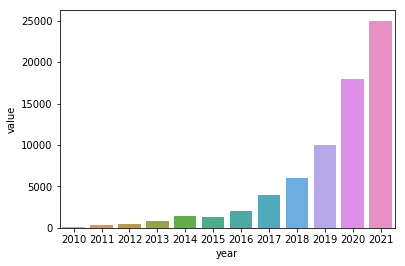

In [65]:
sales_sp_by_year = sales_in_spain_bev.groupby('year')['value'].sum()
sales_sp_by_year = sales_sp_by_year.reset_index()
sns.barplot(data=sales_sp_by_year,x='year',y='value');
#plt.bar(sales_sp_by_year['year'],sales_sp_by_year['value'],width=.6);

In [66]:
sales_sp_by_year

,year,value
0,2010,76.0
1,2011,390.0
2,2012,430.0
3,2013,810.0
4,2014,1400.0
5,2015,1300.0
6,2016,2000.0
7,2017,3900.0
8,2018,6000.0
9,2019,10000.0


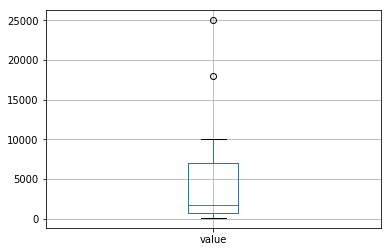

In [67]:
sales_sp_by_year[['value']].boxplot();

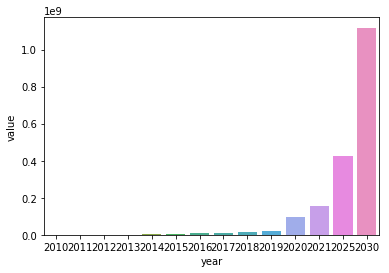

In [68]:
sales_world_by_year = df_el.groupby('year')['value'].sum()
sales_world_by_year = sales_world_by_year.reset_index()
sns.barplot(data=sales_world_by_year,x='year',y='value');
#plt.bar(sales_sp_by_year['year'],sales_world_by_year['value'],width=.6);

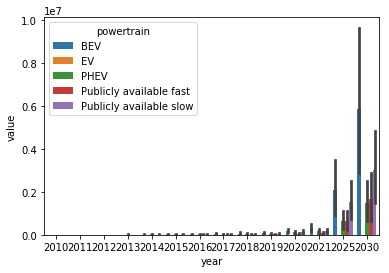

In [69]:
sns.barplot(data=df_el,x='year',y='value',hue='powertrain');

In [ ]:
df_el

### World Population Dataset

## Let's load this dataset

In [70]:
df_population = pd.read_csv("./world_population.csv")

In [ ]:
df_population.head()

In [ ]:
# There 
df_population.info()

In [ ]:
# Let's see a summary of this dataset
df_population.describe()

In [ ]:
### World Population Dataset
# We have a dataset with 234 rows and 17 columns (variables) and no nulls 
# Rank: Rank by population
# CCA3: 3 digit Country/Territories code
# Country: Name of the Country/Territories
# Capital: Name of the Capital
# Continent: Name of the Continent
# 2022 Population: Population of the Country/Territories in the year 2022
# 2020 Population: Population of the Country/Territories in the year 2020
# 2015 Population: Population of the Country/Territories in the year 2015
# 2010 Population: Population of the Country/Territories in the year 2010
# 2000 Population: Population of the Country/Territories in the year 2000
# 1990 Population: Population of the Country/Territories in the year 1990
# 1980 Population: Population of the Country/Territories in the year 1980
# 1970 Population: Population of the Country/Territories in the year 1970
# Area (km²): Area size of the Country/Territories in square kilometer
# Density (per km²): Population density per square kilometer
# Growth Rate: Population growth rate by Country/Territories
# World Population Percentage: The population percentage by each Country/Territories

In [ ]:
df_population[df_population['Country/Territory']=='Spain']

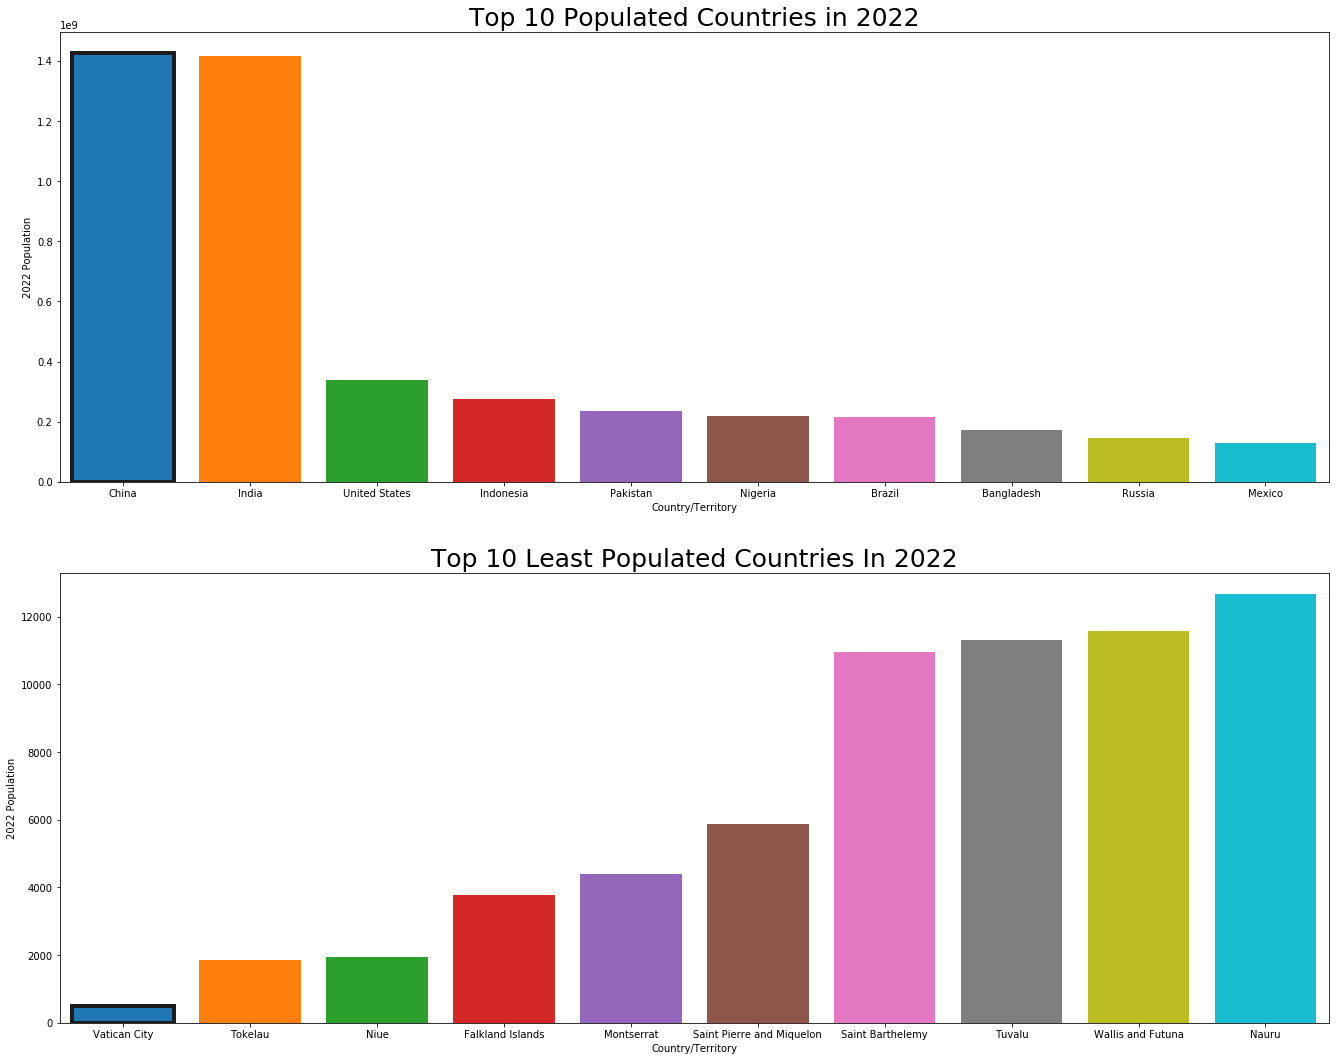

In [71]:
_, axs = plt.subplots(2,1,figsize=(20,16))
plt.tight_layout(pad=7.0)

sns.barplot(x=df_population["Country/Territory"],y=df_population["2022 Population"],order=df_population.sort_values("2022 Population",ascending=False)["Country/Territory"][:10],ax=axs[0], saturation=1,edgecolor = "#1c1c1c", linewidth = 4);
axs[0].set_title("Top 10 Populated Countries in 2022",fontsize=25)

sns.barplot(x=df_population["Country/Territory"],y=df_population["2022 Population"],order=df_population.sort_values("2022 Population",ascending=True)["Country/Territory"][:10],ax=axs[1], saturation=1,edgecolor = "#1c1c1c", linewidth = 4)

axs[1].set_title("Top 10 Least Populated Countries In 2022",fontsize=25);
#axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation = 0)


In [72]:
df_population.sort_values("2022 Population",ascending=False)

,Rank,CCA3,Country/Territory,Capital,Continent,2022 Population,2020 Population,2015 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Area (km²),Density (per km²),Growth Rate,World Population Percentage
41,1,CHN,China,Beijing,Asia,1425887337,1424929781,1393715448,1348191368,1264099069,1153704252,982372466,822534450,9706961,146.8933,1.0000,17.88
92,2,IND,India,New Delhi,Asia,1417173173,1396387127,1322866505,1240613620,1059633675,870452165,696828385,557501301,3287590,431.0675,1.0068,17.77
221,3,USA,United States,"Washington, D.C.",North America,338289857,335942003,324607776,311182845,282398554,248083732,223140018,200328340,9372610,36.0935,1.0038,4.24
93,4,IDN,Indonesia,Jakarta,Asia,275501339,271857970,259091970,244016173,214072421,182159874,148177096,115228394,1904569,144.6529,1.0064,3.45
156,5,PAK,Pakistan,Islamabad,Asia,235824862,227196741,210969298,194454498,154369924,115414069,80624057,59290872,881912,267.4018,1.0191,2.96
149,6,NGA,Nigeria,Abuja,Africa,218541212,208327405,183995785,160952853,122851984,95214257,72951439,55569264,923768,236.5759,1.0241,2.74
27,7,BRA,Brazil,Brasilia,South America,215313498,213196304,205188205,196353492,175873720,150706446,122288383,96369875,8515767,25.2841,1.0046,2.70
16,8,BGD,Bangladesh,Dhaka,Asia,171186372,167420951,157830000,148391139,129193327,107147651,83929765,67541860,147570,1160.0350,1.0108,2.15
171,9,RUS,Russia,Moscow,Europe,144713314,145617329,144668389,143242599,146844839,148005704,138257420,130093010,17098242,8.4636,0.9973,1.81
131,10,MEX,Mexico,Mexico City,North America,127504125,125998302,120149897,112532401,97873442,81720428,67705186,50289306,1964375,64.9082,1.0063,1.60


In [73]:
df_cont = df_population.copy()
df_cont = pd.DataFrame(df_cont.groupby(["Continent"])["1970 Population","1980 Population","1990 Population","2000 Population","2010 Population","2015 Population","2020 Population","2022 Population"].sum())


In [74]:
df_cont

,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population,2015 Population,2020 Population,2022 Population
Continent,,,,,,,,
Africa,365444348,481536377,638150629,818946032,1055228072,1201102442,1360671810,1426730932
Asia,2144906290,2635334228,3210563577,3735089604,4220041327,4458250182,4663086535,4721383274
Europe,655923991,692527159,720320797,726093423,735613934,741535608,745792196,743147538
North America,315434606,368293361,421266425,486069584,542720651,570383850,594236593,600296136
Oceania,19480270,22920240,26743822,31222778,37102764,40403283,43933426,45038554
South America,192947156,241789006,297146415,349634282,393078250,413134396,431530043,436816608


In [75]:
df_cont.sort_values("2022 Population",ascending=False)

,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population,2015 Population,2020 Population,2022 Population
Continent,,,,,,,,
Asia,2144906290,2635334228,3210563577,3735089604,4220041327,4458250182,4663086535,4721383274
Africa,365444348,481536377,638150629,818946032,1055228072,1201102442,1360671810,1426730932
Europe,655923991,692527159,720320797,726093423,735613934,741535608,745792196,743147538
North America,315434606,368293361,421266425,486069584,542720651,570383850,594236593,600296136
South America,192947156,241789006,297146415,349634282,393078250,413134396,431530043,436816608
Oceania,19480270,22920240,26743822,31222778,37102764,40403283,43933426,45038554


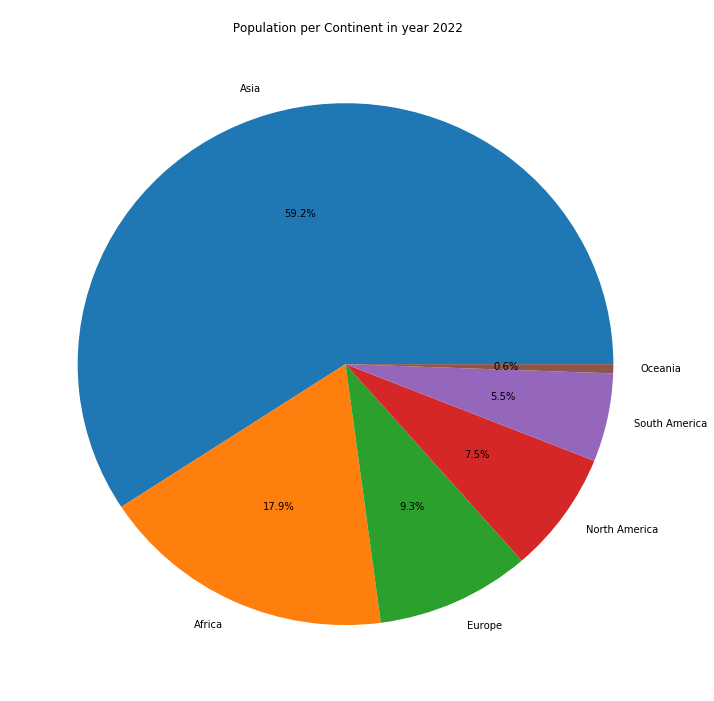

In [76]:
plt.subplots(figsize=(12, 12))

#fig, ax = plt.subplots()
labels = "Asia","Africa","Europe","North America","South America","Oceania"

sizes = [df_cont.sort_values("2022 Population",ascending=False)["2022 Population"][0],
         df_cont.sort_values("2022 Population",ascending=False)["2022 Population"][1],
         df_cont.sort_values("2022 Population",ascending=False)["2022 Population"][2],
         df_cont.sort_values("2022 Population",ascending=False)["2022 Population"][3],
         df_cont.sort_values("2022 Population",ascending=False)["2022 Population"][4],
         df_cont.sort_values("2022 Population",ascending=False)["2022 Population"][5]]
#size = 0.5

plt.pie(sizes,labels=labels,autopct='%1.1f%%');

plt.title("\n Population per Continent in year 2022")
plt.show()
#ax.pie(sizes,labels = labels,autopct='%1.1f%%');

In [77]:
df_population.sort_values("Growth Rate",ascending=False)["Country/Territory"][:11]

133     Moldova
164      Poland
148       Niger
202       Syria
189    Slovakia
55     DR Congo
130     Mayotte
39         Chad
5        Angola
124        Mali
192     Somalia
Name: Country/Territory, dtype: object

In [79]:
df_population.sort_values("Growth Rate",ascending=False)["Country/Territory"][0]

'Afghanistan'

In [ ]:
df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][0]

In [ ]:
df_population.sort_values("Growth Rate",ascending=False)["Country/Territory"][1]

In [ ]:
df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][1]

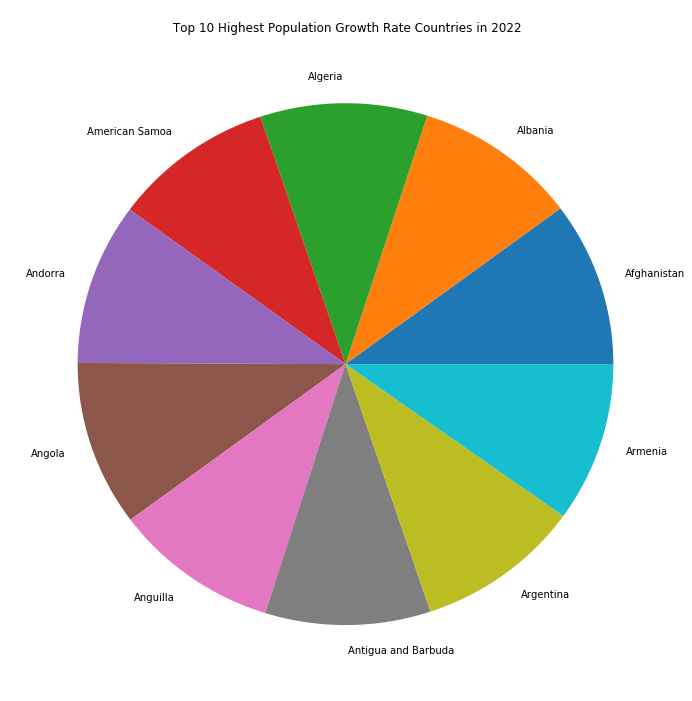

In [80]:
plt.subplots(figsize=(12, 12))

#fig, ax = plt.subplots()
labels = df_population["Country/Territory"][:10]
#x=df_population["Country/Territory"]

sizes = [df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][0],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][1],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][2],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][3],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][4],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][5],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][6],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][7],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][8],
         df_population.sort_values("Growth Rate",ascending=False)["Growth Rate"][9]]

#size = 0.5

plt.pie(sizes,labels=labels);
#plt.pie(sizes,labels=labels,autopct='%1.1f%%');

plt.title("\n Top 10 Highest Population Growth Rate Countries in 2022")
plt.show()
#ax.pie(sizes,labels = labels,autopct='%1.1f%%');

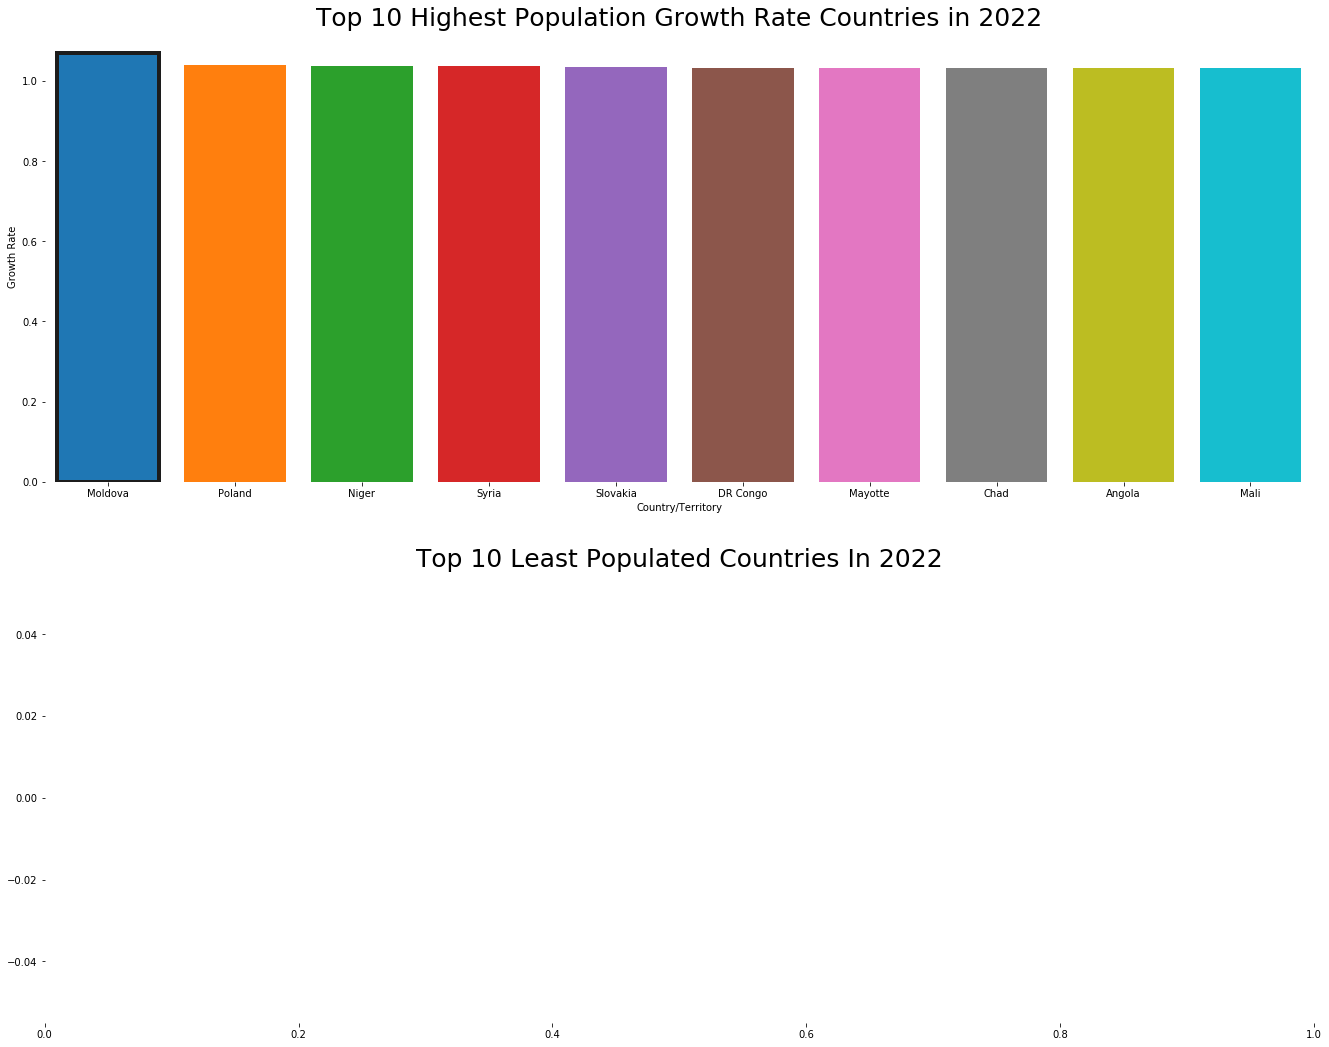

In [81]:
_, axs = plt.subplots(2,1,figsize=(20,16))
plt.tight_layout(pad=7.0)

sns.barplot(x=df_population["Country/Territory"],y=df_population["Growth Rate"],order=df_population.sort_values("Growth Rate",ascending=False)["Country/Territory"][:10],ax=axs[0], saturation=1,edgecolor = "#1c1c1c", linewidth = 4)
axs[1].set_yscale("linear")
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation = 0)
sns.despine(left=True, bottom=True)
#axs[0].bar_label()
#sns.barplot(x=df_population.sort_values("Growth Rate",ascending=False)["Country/Territory"],y=df_population["Growth Rate"],order=df_population.sort_values("2022 Population",ascending=False)["Country/Territory"][:10],ax=axs[0], saturation=1,edgecolor = "#1c1c1c", linewidth = 4);
axs[0].set_title("Top 10 Highest Population Growth Rate Countries in 2022",fontsize=25)

#sns.barplot(x=df_population["Country/Territory"],y=df_population["2022 Population"],order=df_population.sort_values("2022 Population",ascending=True)["Country/Territory"][:10],ax=axs[1], saturation=1,edgecolor = "#1c1c1c", linewidth = 4)

axs[1].set_title("Top 10 Least Populated Countries In 2022",fontsize=25);
#axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation = 0)

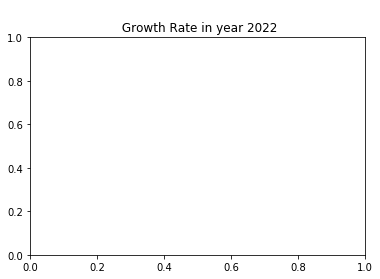

In [82]:
sns.barplot(x=df_population["Country/Territory"],y=df_population["2022 Population"],order=df_population.sort_values("2022 Population",ascending=True)["Country/Territory"][:10],ax=axs[1], saturation=1,edgecolor = "#1c1c1c", linewidth = 4);
plt.title("\n Growth Rate in year 2022")
plt.show()
#ax.pie(sizes,

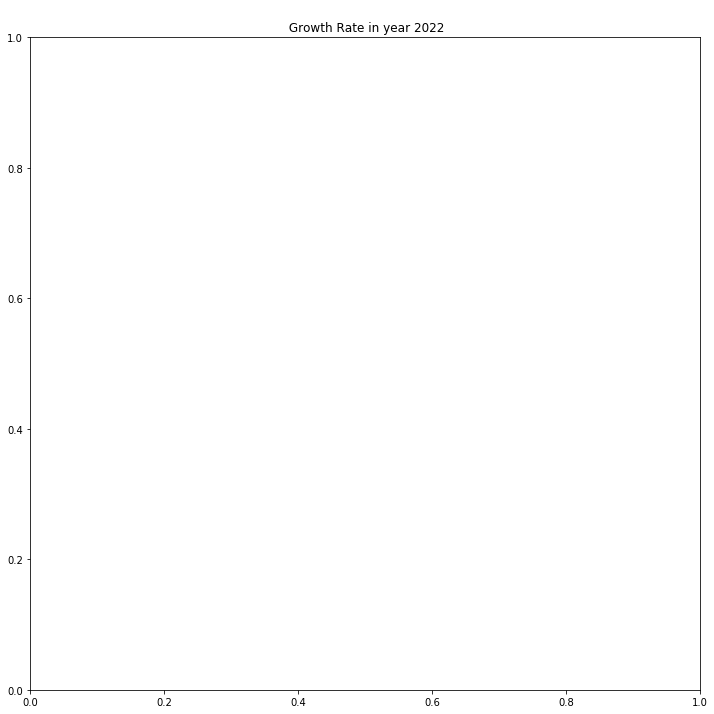

In [83]:
plt.subplots(figsize=(12, 12))

#fig, ax = plt.subplots()
labels = "Asia","Africa","Europe","North America","South America","Oceania"


sns.barplot(x=df_population["Country/Territory"],y=df_population["Growth Rate"],order=df_population.sort_values("Growth Rate",ascending=False)["Country/Territory"][:11],ax=axs[0], saturation=1,edgecolor = "#1c1c1c", linewidth = 4)
axs[0].set_yscale("linear")
axs[0].set_title("Highest Population Growth Rate Countries",fontsize=25)
axs[0].set_xlabel("\nCountry",fontsize=20)
axs[0].set_ylabel("Growth Rate",fontsize=20)
plt.title("\n Growth Rate in year 2022")
plt.show()
#ax.pie(sizes,labels = labels,autopct='%1.1f%%');

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

In [ ]:
# Performing cleaning tasks here





### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Write code here

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.